Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



In [3]:
import numpy as np

## Implementation of logistic regression model

In [4]:
def sigmoid(t: np.ndarray, x: np.ndarray):
    """
    Sigmoid (logistic) function:
    calculates hypothesis value from given arrays of 
    coefficients thetas (t) and single observation (x)
    """
    dot_product = np.dot(t.T, x)
    
    #Avoid calculating e^(large numbers). In this case value of 
    #sigmoid function can be approximated to 0.
    if dot_product < -10:
        return(0)
    else:
        return(1/(1+np.exp(-dot_product)))

In [5]:
def sgd(t: np.ndarray, X: np.ndarray, y: np.ndarray, 
        a, b, maxit, step, l):
    """
    Stochastic gradient descent with momentum and L@ regularization
    input:
        - t: parameters theta (start vector)
        - X: features set
        - y: labels vector
    parameters:
        - defined in Model class
    output:
        - vector of thetas which optimized cost function
    """
    
    #Number of features (theta params)
    num_feat = t.size
    #Number of observations
    num_obs = len(X)
    
    #Initialize past time step with 0 value
    v_prev = 0
    
    k=0
    flag=True
    while(flag):
        
        for row_id in range(0,num_obs,step):
            
            #Computing gradient
            gradient = (sigmoid(t, X[row_id])-y[row_id])*X[row_id]
            #Computing step
            v = b*v_prev + a*gradient
            #Actualizing thetas
            t = t - v + (a*l/num_obs)*t
            
            v_prev = v
            k+=1
            if(k>maxit):
                flag = False
                break
    
    return(t)

In [27]:
class Model:
    """
    Logistic regression with SGD-momentum solver
    Parameters:
        - a: learning parameter
        - b: momentum parameter
        - maxit: maximum number of iterations
        - step: step while iterating over observations when calculating gradients
        - l: L2 regularization strength 
    """
    #Theta parameters
    t = None
    
    def __init__(self, a=1, b=0.9, maxit=10000, l=0, step=1):
        self.a = a
        self.b = b
        self.maxit = maxit
        self.l = l
        self.step = step
    
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Trains model on given train set X and labels y"""
        
        #Initialize thetas to zeros vector
        t_start = np.zeros(len(X[0]))
        
        #Run optimalization algorithm and assign output to t
        self.t = sgd(t_start, X, y, self.a, self.b, self.maxit, self.step, self.l)
        

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Computes class prediction on given dataset"""
        
        probability = np.array([sigmoid(self.t, Xi) for Xi in X])
        pred = np.where(probability>=0.5, 1, 0)
        return(pred)

    
    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        # calculate accuracy
        return(y_true == y_pred).mean()

## Loading datasets

In [23]:
def loadMNIST( prefix ):
    """Loads MNIST dataset and its labels from files"""
    
    intType = np.dtype('int32').newbyteorder('>')
    nMetaDataBytes = 4 * intType.itemsize
    
    data = np.fromfile("./" + prefix + '-images-idx3-ubyte', dtype = 'ubyte')
    magicBytes, nImages, width, height = np.frombuffer(data[:nMetaDataBytes].tobytes(), intType)
    data = data[nMetaDataBytes:].astype(dtype = 'float32').reshape([ nImages, width, height ])
    data = data.reshape((data.shape[0], -1), order='F')
    
    labels = np.fromfile("./" + prefix + '-labels-idx1-ubyte',dtype = 'ubyte')[2 * intType.itemsize:]
    
    return data, labels

In [24]:
X_train, y_train = loadMNIST("train")
X_test, y_test = loadMNIST("t10k")

#Mapping orginal classes to binary as defined in task description
y_train = np.isin(y_train, [2,3,5,7])*1
y_test = np.isin(y_test, [2,3,5,7])*1

## Short EDA
For this porpouse I will use pandas and matplotlib packages.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
temp_X = pd.DataFrame(X_train)
temp_y = pd.Series(y_train)

### Balance of target variable:
Target classes are equal enough to assume that dataset is balanced,
hence accuracy is right metric, techniques for imbalanced data are not needed.

In [20]:
temp_y.value_counts()

0    36225
1    23775
dtype: int64

### Values distribution
Pixels values are extremely imbalanced. Most pixels' values are equal to 0 and the second significant group is set of values close to maximum (251-255). Because of that it is worth to consider if transforming images to black-and-white or normalization will improve results.  

In [21]:
pixels_val = pd.DataFrame(temp_X.stack().value_counts())
temp_X.stack().describe().apply(lambda x: format(x, 'f'))

count    47040000.000000
mean           33.495377
std            73.746880
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           255.000000
dtype: object

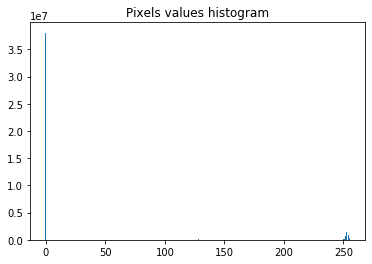

In [22]:
f = plt.figure()
plt.title("Pixels values histogram")
plt.bar(pixels_val.index, pixels_val[0])
plt.show()

### Constant pixels
Pixels (features) where all values are equal among all observations. Removing them from dataset seems to be reasonable.

In [23]:
print("Number of pixels with constant values")
len(temp_X.std()[(temp_X.std() == 0)].index)

Number of pixels with constant values


67

## Preprocessing and features engineering
Basing on above brief EDA I will prepear dataset modified with feature engineering. In final model scoring I will compare results between this and orginal dataset.

In [25]:
#1. Removing constant pixels
def remove_constant_cols(train, test):
    #Constant in train set
    constant = np.all(train[1:] == train[:-1], axis=0)
    #Remove same columns from train and test sets
    train = train[:, ~constant]
    test = test[:, ~constant]
    return(train, test)

X_train_fe, X_test_fe = remove_constant_cols(X_train, X_test)

In [26]:
#2. Normalization
X_train_fe = X_train/255
X_test_fe = X_test/255

# Model evaluation
1. To find best hyperparameters I will use cross-validation method on training set.
2. Best models will be scored on test set.
3. Best results on orginal and modified dataset will be compared.

In [8]:
def param_tune_cv(model, k, params, X, y):
    """
    Hyperparameters tuning with grid search c-v method
    Parameters:
        - params: matrix of parameters values to test
        - k: number of folds
    Output:
        - matrix of results: [mean(acc), std(acc), params]
    """
    a_set = params[0]
    b_set = params[1]
    maxit_set = params[2]
    l_set = params[3]
    step_set = params[4]
    
    #Creating cartesian product of parameters' values
    params_set = [(a, b, maxit, l, step) for a in a_set 
                  for b in b_set 
                  for maxit in maxit_set 
                  for l in l_set
                  for step in step_set]
    
    total = str(len(params_set))
    
    #Shuffling data in given X set and target, with the same permutation
    id = np.random.permutation(len(X))
    X = [X[i] for i in id]
    y = [y[i] for i in id]
        
    num = int(np.floor(len(X)/k))
    
    #Creating lists of trainig and validation sets
    validate_sets = [None]*k
    train_sets = [None]*k
    train_y = [None]*k
    validate_y = [None]*k
    
    
    for j in range(k-1):
        X_validate = X[j*num : (j+1)*num]
        X_train = np.delete(X, range(j*num, (j+1)*num), 0)
        
        y_validate = y[j*num : (j+1)*num]
        y_train = np.delete(y, range(j*num, (j+1)*num))
        
        validate_sets[j] = X_validate
        train_sets[j] = X_train
        validate_y[j] = y_validate
        train_y[j] = y_train
    
    validate_sets[k-1] = X[(k-1)*num:]
    train_sets[k-1] = np.delete(X, range((k-1)*num, len(X)-1), 0)
    validate_y[k-1] = y[(k-1)*num:]
    train_y[k-1] = np.delete(y, range((k-1)*num, len(X)-1))
    
    #Now with ready k train and validetion sets computing mean and std of accuracy 
    #depends on different parameter values
    results = []
    
    cur = 0
    for i in params_set:
        
        acc = [None]*k
        
        for j in range(k):
            
            #Training model
            log_reg = Model(a=i[0],b=i[1],maxit=i[2],l=i[3],step=i[4])
            log_reg.fit(train_sets[j], train_y[j])
            #Prediction and score on current validation set
            pred = log_reg.predict(validate_sets[j])
            score = log_reg.evaluate(validate_y[j], pred)
            acc[j] = score
            
        r = [np.mean(acc), np.std(acc)]
        r.extend(i)
        results.append(r)
        cur+=1
        print("Done: " + str(cur) + " /" + total)
                
    return(results)

In [32]:
#Number of observations in single c-v train set
k = 5
num = (k-1)*len(X_train)/k

#Parameters for grid search c-v
par = [[0.01, 0.1, 0.9, 1, 1.1],
      [0.01, 0.1, 0.9, 1, 1.1],
      [0.1*num, 0.5*num, num, 2*num],
      [0.001, 0.01, 0.1, 1, 10],
      [1]]

In [ ]:
#Cross_validation for orginal dataset
result_org = param_tune_cv(Model(), 5, par, X_train, y_train)

In [59]:
#Cross_validation for dataset after feature engineering
result_fe = param_tune_cv(Model(), 5, par, X_train_fe, y_train)

Done: 1 /500
Done: 2 /500
Done: 3 /500
Done: 4 /500
Done: 5 /500
Done: 6 /500
Done: 7 /500
Done: 8 /500
Done: 9 /500
Done: 10 /500
Done: 11 /500
Done: 12 /500
Done: 13 /500
Done: 14 /500
Done: 15 /500
Done: 16 /500
Done: 17 /500
Done: 18 /500
Done: 19 /500
Done: 20 /500
Done: 21 /500
Done: 22 /500
Done: 23 /500
Done: 24 /500
Done: 25 /500
Done: 26 /500
Done: 27 /500
Done: 28 /500
Done: 29 /500
Done: 30 /500
Done: 31 /500
Done: 32 /500
Done: 33 /500
Done: 34 /500
Done: 35 /500
Done: 36 /500
Done: 37 /500
Done: 38 /500
Done: 39 /500
Done: 40 /500
Done: 41 /500
Done: 42 /500
Done: 43 /500
Done: 44 /500
Done: 45 /500
Done: 46 /500
Done: 47 /500
Done: 48 /500
Done: 49 /500
Done: 50 /500
Done: 51 /500
Done: 52 /500
Done: 53 /500
Done: 54 /500
Done: 55 /500
Done: 56 /500
Done: 57 /500
Done: 58 /500
Done: 59 /500
Done: 60 /500
Done: 61 /500
Done: 62 /500
Done: 63 /500
Done: 64 /500
Done: 65 /500
Done: 66 /500
Done: 67 /500
Done: 68 /500
Done: 69 /500
Done: 70 /500
Done: 71 /500
Done: 72 /500
D

/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater_equal


Done: 81 /500
Done: 82 /500
Done: 83 /500
Done: 84 /500
Done: 85 /500
Done: 86 /500
Done: 87 /500
Done: 88 /500
Done: 89 /500
Done: 90 /500
Done: 91 /500
Done: 92 /500
Done: 93 /500
Done: 94 /500
Done: 95 /500
Done: 96 /500
Done: 97 /500
Done: 98 /500
Done: 99 /500
Done: 100 /500
Done: 101 /500
Done: 102 /500
Done: 103 /500
Done: 104 /500
Done: 105 /500
Done: 106 /500
Done: 107 /500
Done: 108 /500
Done: 109 /500
Done: 110 /500
Done: 111 /500
Done: 112 /500
Done: 113 /500
Done: 114 /500
Done: 115 /500
Done: 116 /500
Done: 117 /500
Done: 118 /500
Done: 119 /500
Done: 120 /500
Done: 121 /500
Done: 122 /500
Done: 123 /500
Done: 124 /500
Done: 125 /500
Done: 126 /500
Done: 127 /500
Done: 128 /500
Done: 129 /500
Done: 130 /500
Done: 131 /500
Done: 132 /500
Done: 133 /500
Done: 134 /500
Done: 135 /500
Done: 136 /500
Done: 137 /500
Done: 138 /500
Done: 139 /500
Done: 140 /500
Done: 141 /500
Done: 142 /500
Done: 143 /500
Done: 144 /500
Done: 145 /500
Done: 146 /500
Done: 147 /500
Done: 148 /500

In [73]:
#Saving results for further work
np.savetxt("orginal.csv", result_orginal, fmt= '%.3e')

In [74]:
np.savetxt("fe.csv", result_fe, fmt= '%.3e')

## Cross-validation results

In [13]:
result_org = pd.read_csv("orginal.csv", header=None, sep=" ")
result_fe = pd.read_csv("fe.csv", header=None, sep=" ")
result_org.columns = ["mean_acc","std_acc","a","b","maxit","l","step"]
result_fe.columns = ["mean_acc","std_acc","a","b","maxit","l","step"]

In [14]:
result_org = result_org.sort_values("mean_acc", ascending=False).reset_index(drop=True)
result_fe = result_fe.sort_values("mean_acc", ascending=False).reset_index(drop=True)

### Best 5 scores: orginal data

In [15]:
result_org.head(5)

,mean_acc,std_acc,a,b,maxit,l,step
0,0.8855,0.001812,1.1,0.90,96000.0,10.0,1.0
1,0.8854,0.001866,1.1,0.90,48000.0,10.0,1.0
2,0.8854,0.003248,1.1,0.01,24000.0,10.0,1.0
3,0.8852,0.003280,0.9,0.01,24000.0,10.0,1.0
4,0.8849,0.003870,1.1,0.10,24000.0,10.0,1.0


### Best 5 scores: data after features engineering

In [16]:
result_fe.head(5)

,mean_acc,std_acc,a,b,maxit,l,step
0,0.8948,0.002138,0.01,0.01,96000.0,10.00,1.0
1,0.8946,0.002180,0.01,0.10,96000.0,10.00,1.0
2,0.8944,0.001991,0.01,0.01,96000.0,1.00,1.0
3,0.8943,0.001994,0.01,0.01,96000.0,0.10,1.0
4,0.8943,0.001994,0.01,0.01,96000.0,0.01,1.0


From c-v results I choose sets of parameters which refer to the best averages of accuracy. Both of them have acceptably low standard deviation.

# Performance on test sets
Best models for two data approaches will be scored on test sets.

### Best model for orginal data

In [17]:
par_org = result_org.iloc[0][2:]

In [18]:
par_org

a            1.1
b            0.9
maxit    96000.0
l           10.0
step         1.0
Name: 0, dtype: float64

In [19]:
model_org = Model(a=par_org[0], b=par_org[1], maxit=par_org[2], l=par_org[3], step=1)

### Best model for data after features engineering

In [20]:
par_fe = result_fe.iloc[0][2:]

In [73]:
par_fe

a            0.01
b            0.01
maxit    96000.00
l           10.00
step         1.00
Name: 0, dtype: float64

In [21]:
model_fe = Model(a=par_fe[0], b=par_fe[1], maxit=par_fe[2], l=par_fe[3], step=1)

### Final scoring

In [28]:
#Trainig best models
model_org.fit(X_train, y_train)
model_fe.fit(X_train_fe, y_train)

In [29]:
#Calculating predictions for test sets
pred_org = model_org.predict(X_test)
pred_fe = model_fe.predict(X_test_fe)

In [30]:
#Computing accuracy of prediction
acc_org = model_org.evaluate(pred_org, y_test)
acc_fe = model_fe.evaluate(pred_fe, y_test)

### Accuracy of best model for orginal data:

In [31]:
print(acc_org)

0.8925


### Accuracy of best model for data after features engineering:

In [32]:
print(acc_fe)

0.8927


## Summary

Value of accuracy metric for both approaches was about 89%.\
This result is quite good and seems to be stable comparing cross-validation and test set scores.\
I managed to get even higher value of accuracy up to about 91%. However result was unstable. Cross-validation method helped to find much more reliable models which perform well on unseen data.\
Features engineering did not help to achive significantly higher scores on test set. On the other hand, equal results mean that reduction of dimensions (features) is possible for this dataset. This conclusion might be useful for building more complex and computationally expensive models.